# Group 20 — Clustering

This notebook performs exploratory data analysis on customer and flights databases, covering data inspection, quality assessment, and preprocessing.

## Table of Contents
- [Data Import](#data-import)
- [Data Preprocessing](#preprocessing)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MeanShift, estimate_bandwidth

# Functions

In [2]:
def winsorize_dataframe(df, columns, limits=(0.01, 0.01)):
    """
    Apply winsorization to each column in `columns`.
    limits=(lower_pct, upper_pct) means: cap values at the 1st and 99th percentile.

    Returns the winsorized copy of df.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            # winsorize returns masked arrays -> convert to normal array
            df[col] = winsorize(df[col], limits=limits).data
    return df

def preprocess_flights(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the FlightsDB:
    - Winsorize outliers
    - Convert YearMonthDate to datetime
    - Round down NumFlights and NumFlightsWithCompanions
    - Set DistanceKM = 0 where NumFlights == 0
    - Drop DollarCostPointsRedeemed
    - Add log-transformed versions of skewed variables
    - Create PointsUtilizationRatio = PointsRedeemed / PointsAccumulated
    """
    df = flights_df.copy()

    # 0. Winsorize outliers (Flights DB outliers are legitimate but skewed)
    outlier_cols = [
        'NumFlights', 'NumFlightsWithCompanions', 'DistanceKM', 
        'PointsAccumulated', 'PointsRedeemed'
    ]
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 1. YearMonthDate -> datetime
    if 'YearMonthDate' in df.columns:
        df['YearMonthDate'] = pd.to_datetime(df['YearMonthDate'])

    # 2. Round down flight counts and cast to int
    for col in ['NumFlights', 'NumFlightsWithCompanions']:
        if col in df.columns:
            df[col] = np.floor(df[col]).astype(int)

    # 3. Fix logical inconsistency: DistanceKM must be 0 if NumFlights == 0
    if {'NumFlights', 'DistanceKM'}.issubset(df.columns):
        df.loc[df['NumFlights'] == 0, 'DistanceKM'] = 0

    # 4. Drop perfectly correlated variable
    if 'DollarCostPointsRedeemed' in df.columns:
        df = df.drop(columns=['DollarCostPointsRedeemed'])

    # 5. Log transforms for skewed numeric variables
    log_cols = ['DistanceKM', 'PointsAccumulated', 'PointsRedeemed', 'NumFlights']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])

    # 6. Points utilisation ratio
    if {'PointsRedeemed', 'PointsAccumulated'}.issubset(df.columns):
        denom = df['PointsAccumulated'].replace({0: np.nan})
        df['PointsUtilizationRatio'] = df['PointsRedeemed'] / denom

    return df

def preprocess_customers(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the CustomerDB:
    - Create cancellation flag from CancellationDate
    - Group-median imputation (by LoyaltyStatus) for Income and Customer Lifetime Value
    - Winsorize outliers (Income, CLV)
    - Log transform Customer Lifetime Value and Income
    - Encode Gender as binary
    """
    df = customer_df.copy()

    # 1. Cancellation flag
    if 'CancellationDate' in df.columns:
        df['CancelledFlag'] = df['CancellationDate'].notna().astype(int)

    # 2. Group-median imputation by LoyaltyStatus
    group_col = 'LoyaltyStatus'
    cols_to_impute = ['Income', 'Customer Lifetime Value']
    for col in cols_to_impute:
        if col in df.columns and group_col in df.columns:
            df[col] = df.groupby(group_col)[col].transform(
                lambda x: x.fillna(x.median())
            )

    # 3. Winsorize outliers
    outlier_cols = ['Income', 'Customer Lifetime Value']
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 4. Log transforms
    if 'Customer Lifetime Value' in df.columns:
        df['CLV_log'] = np.log1p(df['Customer Lifetime Value'])
    if 'Income' in df.columns:
        df['Income_log'] = np.log1p(df['Income'].clip(lower=0))

    # 5. Gender encoding
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({'female': 1, 'male': 0}).fillna(0).astype(int)

    # 6. Education to Years (Ordinal Encoding)
    if 'Education' in df.columns:
        edu_map = {
            'High School or Below': 12,
            'College': 14,
            'Bachelor': 16,
            'Master': 18,
            'Doctor': 21
        }
        df['Education'] = df['Education'].map(edu_map)
        df['Education'] = df['Education'].fillna(16)

    # 7. Turn marital status into a flag
    if 'Marital Status' in df.columns:
        df['Marital Status'] = np.where(df['Marital Status'] != 'Married', 1, 0)

    return df

def build_customer_flight_features(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate monthly flight records into customer-level features:
    - TotalFlights, TotalDistanceKM, TotalPointsAccumulated, TotalPointsRedeemed
    - MeanPointsUtilization
    - AverageFlightDistance
    """
    id_col = 'Loyalty#'
    df = flights_df.copy()
    
    agg = (
        df
        .groupby(id_col)
        .agg(
            TotalFlights=('NumFlights', 'sum'),
            TotalDistanceKM=('DistanceKM', 'sum'),
            TotalPointsAccumulated=('PointsAccumulated', 'sum'),
            TotalPointsRedeemed=('PointsRedeemed', 'sum'),
            MeanPointsUtilization=('PointsUtilizationRatio', 'mean')
        )
        .reset_index()
    )

    # Log transforms for aggregated features
    for col in ['TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated', 'TotalPointsRedeemed']:
        agg[f'{col}_log'] = np.log1p(agg[col])
    
    # Average flight distance
    agg['AverageFlightDistance'] = agg['TotalDistanceKM'] / agg['TotalFlights'].replace({0: np.nan})

    return agg

def create_model_df(customer_df: pd.DataFrame, flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Orchestrates the creation of the final modeling dataframe:
    1. Preprocess customers and flights
    2. Build customer-level flight features
    3. Merge datasets (Left Join)
    4. Set Loyalty# as Index
    5. Handle missing values
    6. Encode categorical variables (OneHotEncoder)
    7. Drop unnecessary columns
    8. Scale numeric features (StandardScaler)
    """
    # 1. Preprocess
    cust_clean = preprocess_customers(customer_df)
    flights_clean = preprocess_flights(flights_df)

    # 2. Build flight features
    flight_features = build_customer_flight_features(flights_clean)

    # 3. Merge
    model_df = cust_clean.merge(flight_features, on='Loyalty#', how='left')

    # 4. Set Loyalty# as Index
    if 'Loyalty#' in model_df.columns:
        model_df.set_index('Loyalty#', inplace=True)

    # 5. Handle Missing Values (Numeric)
    numeric_cols_to_fill = model_df.select_dtypes(include=[np.number]).columns
    model_df[numeric_cols_to_fill] = model_df[numeric_cols_to_fill].fillna(0)

    # 6. Drop unnecessary columns
    cols_to_drop = [
        'First Name', 'Last Name', 'CancellationDate', 'Customer Name',
        'Country', 'Province or State', 'City', 'Postal Code',
        'Latitude', 'Longitude', 'EnrollmentDateOpening', 'EnrollmentType',
        'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated', 'TotalPointsRedeemed',
        'Customer Lifetime Value', 'Income'
    ]
    model_df = model_df.drop(columns=[c for c in cols_to_drop if c in model_df.columns], errors='ignore')

    # 7. Separate Numeric and Categorical
    categorical_cols = ['LoyaltyStatus', 'Location Code']
    categorical_cols = [c for c in categorical_cols if c in model_df.columns]
       
    numeric_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude binary/ordinal from scaling
    unscaled_cols = []
    for col in ['CancelledFlag', 'Marital Status', 'Gender']:
        if col in numeric_cols:
            numeric_cols.remove(col)
            unscaled_cols.append(col)

    # 8. OneHotEncoding
    ohe = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
    encoded_data = ohe.fit_transform(model_df[categorical_cols])
    encoded_cols = ohe.get_feature_names_out(categorical_cols)
    
    df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=model_df.index)
    
    # 9. Scale Numeric Features
    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(model_df[numeric_cols])
    df_numeric_scaled = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=model_df.index)
    
    # 10. Combine
    dfs_to_concat = [df_numeric_scaled, df_encoded]
    if unscaled_cols:
        dfs_to_concat.append(model_df[unscaled_cols])
        
    df_final = pd.concat(dfs_to_concat, axis=1)
    
    return df_final


# <a id="data-import"></a> Data Import

In [3]:
# Load the data
customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 )
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv")

# <a id="preprocessing"></a> Data Preprocessing

In this section we apply the preprocessing and feature engineering steps
described in the report:

- Fix data types and logical inconsistencies in **FlightsDB**
- Handle missing values and transform skewed variables in **CustomerDB**
- Create new features: log-transformed variables, points utilisation,
  cancellation flag, customer value score, flight activity score, and
  average flight distance.



In [4]:
# Remove duplicates in customer database
initial_rows = customer_db.shape[0]
duplicated_loyalty_ids = customer_db[customer_db['Loyalty#'].duplicated()]['Loyalty#'].unique()
customer_db = customer_db.drop_duplicates(subset=['Loyalty#'])
dropped_rows = initial_rows - customer_db.shape[0]
dropped_percentage = (dropped_rows / initial_rows) * 100

print(f"Dropped {dropped_rows} duplicate customers ({dropped_percentage:.2f}%).")
# Note: We do not filter flights_db here because the inner join later will automatically exclude flights from dropped customers.

Dropped 164 duplicate customers (0.97%).


In [5]:
# Create the modeling dataset using the pipeline function
# This handles preprocessing, merging, missing values, encoding, feature selection AND scaling
model_df = create_model_df(customer_db, flights_db)


model_df.head()

,Education,CLV_log,Income_log,MeanPointsUtilization,TotalFlights_log,TotalDistanceKM_log,TotalPointsAccumulated_log,TotalPointsRedeemed_log,AverageFlightDistance,LoyaltyStatus_Nova,LoyaltyStatus_Star,Location Code_Suburban,Location Code_Urban,CancelledFlag,Marital Status,Gender
Loyalty#,,,,,,,,,,,,,,,,
480934,0.247015,-0.763202,0.677739,-0.246381,0.522795,0.488886,0.531688,0.738129,0.592418,0,1,0,1,0,0,1
549612,-0.946877,-0.763013,-1.710038,0.405034,0.776343,0.434159,0.474574,0.807722,-0.431266,0,1,0,0,0,1,0
429460,-0.946877,-0.762956,-1.710038,0.224053,0.232401,0.262309,0.281551,0.529479,-0.101999,0,1,0,1,1,1,0
608370,-0.946877,-0.762956,-1.710038,0.378357,0.546334,0.421397,0.441299,0.784274,0.032897,0,1,1,0,0,1,0
530508,0.247015,-0.761729,0.748927,-0.429428,0.461702,0.399873,0.426560,-1.479347,0.130452,0,1,1,0,0,0,0


In [6]:
# Define feature categories for profile and behavior segmentation
behavior_features = [
    'TotalFlights_log', 'TotalDistanceKM_log', 'TotalPointsAccumulated_log', 
    'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance', 
    'CancelledFlag'
]

profile_features = [
    'CLV_log', 'Income_log', 'Gender', 'Education', 'Marital Status',
    'LoyaltyStatus_Nova', 'LoyaltyStatus_Star', 
    'Location Code_Suburban', 'Location Code_Urban'
]

print(f"Behavior features: {behavior_features}")
print(f"Profile features: {profile_features}")


Behavior features: ['TotalFlights_log', 'TotalDistanceKM_log', 'TotalPointsAccumulated_log', 'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance', 'CancelledFlag']
Profile features: ['CLV_log', 'Income_log', 'Gender', 'Education', 'Marital Status', 'LoyaltyStatus_Nova', 'LoyaltyStatus_Star', 'Location Code_Suburban', 'Location Code_Urban']


In [7]:
# Check for missing values in the model dataframe
model_df.isnull().sum()


Education                     0
CLV_log                       0
Income_log                    0
MeanPointsUtilization         0
TotalFlights_log              0
TotalDistanceKM_log           0
TotalPointsAccumulated_log    0
TotalPointsRedeemed_log       0
AverageFlightDistance         0
LoyaltyStatus_Nova            0
LoyaltyStatus_Star            0
Location Code_Suburban        0
Location Code_Urban           0
CancelledFlag                 0
Marital Status                0
Gender                        0
dtype: int64

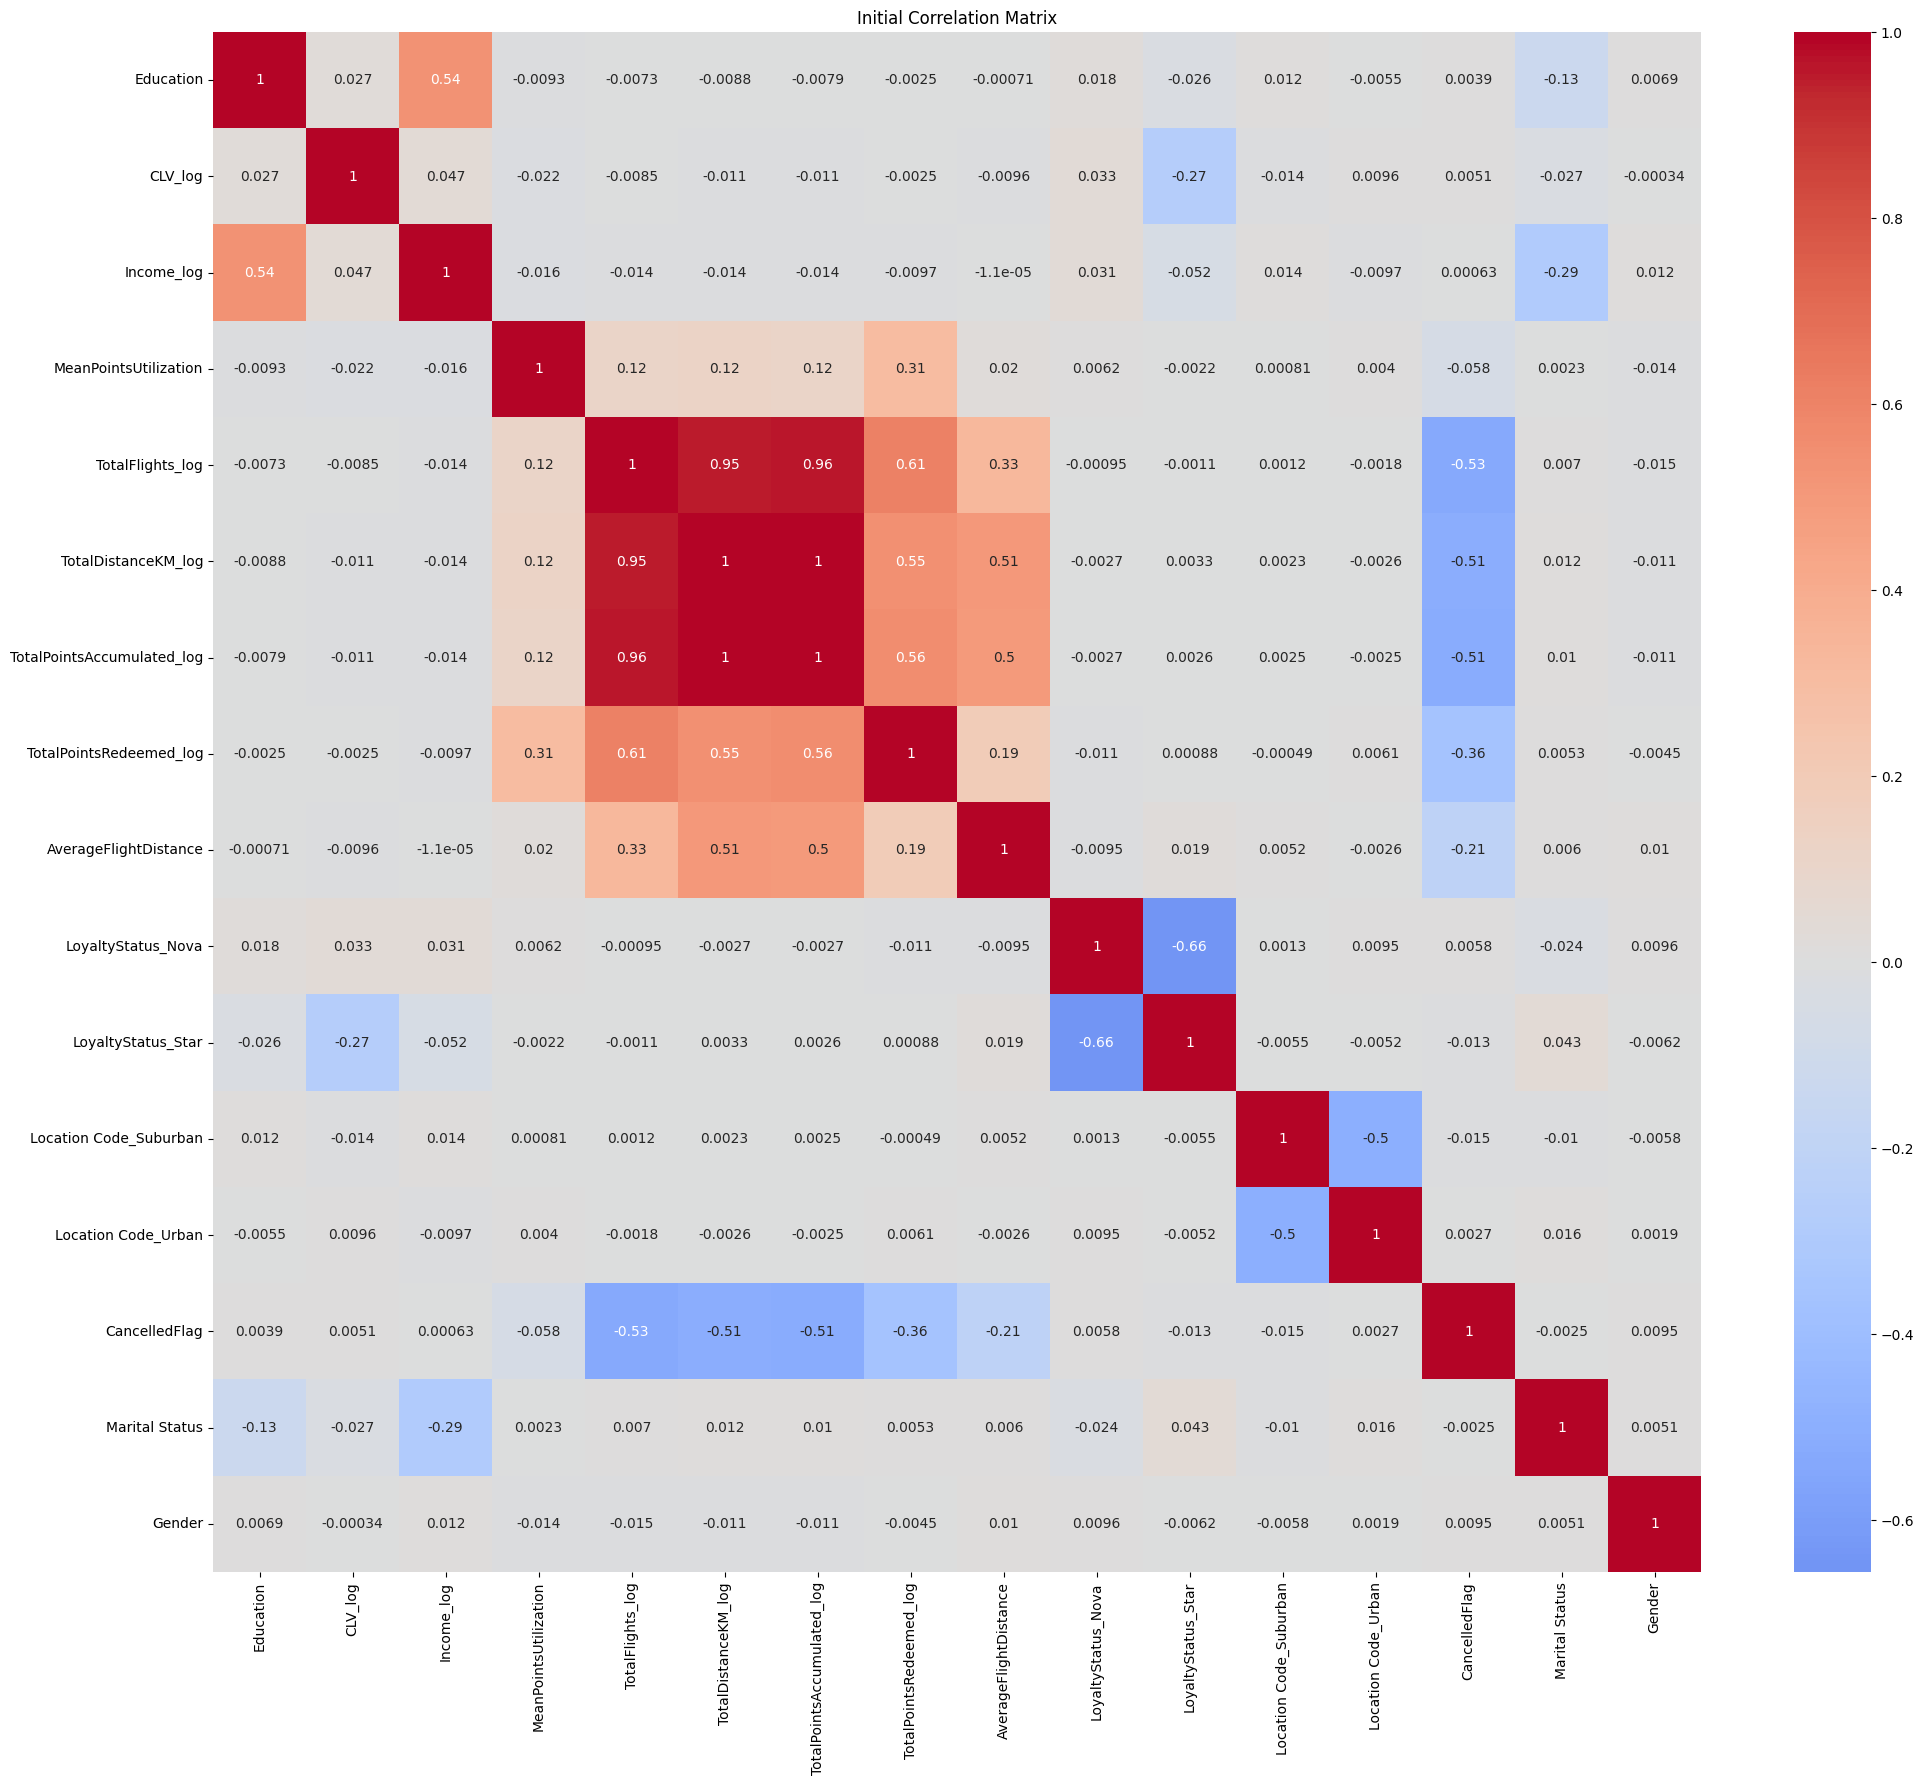

Dropping highly correlated features: ['TotalDistanceKM_log', 'TotalPointsAccumulated_log']
Updated behavior features: ['TotalFlights_log', 'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance', 'CancelledFlag']
Updated profile features: ['CLV_log', 'Income_log', 'Gender', 'Education', 'Marital Status', 'LoyaltyStatus_Nova', 'LoyaltyStatus_Star', 'Location Code_Suburban', 'Location Code_Urban']


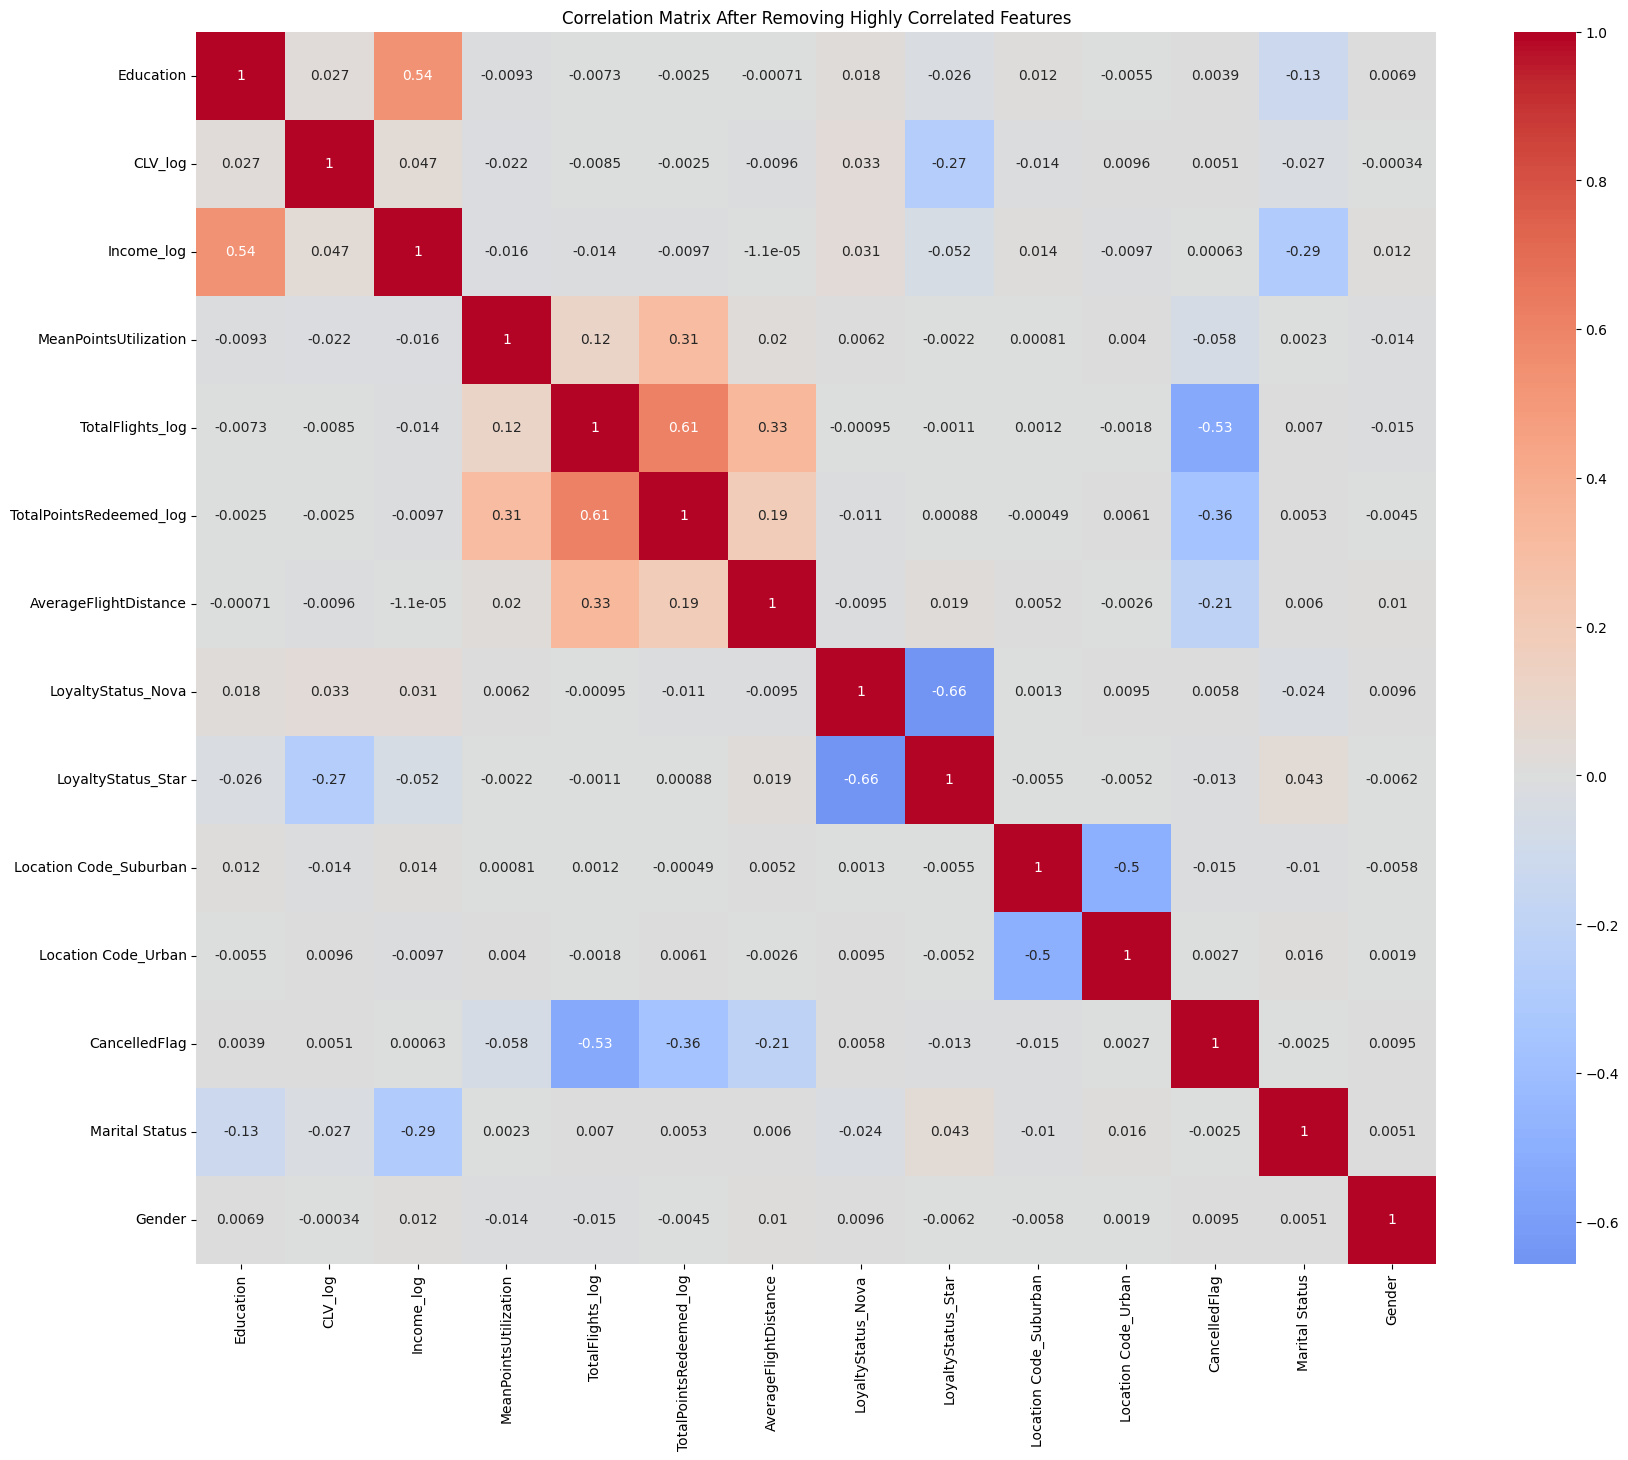

In [8]:
# Correlation Analysis and Feature Selection
# 1. Plot initial correlation matrix
plt.figure(figsize=(24, 20))
initial_corr = model_df.corr()
sns.heatmap(initial_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Initial Correlation Matrix')
plt.show()

# 2. Identify and remove highly correlated features (> 0.8)
# We use the absolute correlation matrix
corr_matrix = model_df.corr().abs()

# We select the upper triangle of the correlation matrix. 
# This ensures that if Feature A and Feature B are correlated, 
# we only see the relationship once (e.g., A vs B, not B vs A).
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# We drop the column (Feature B) if it has a correlation > 0.8 with any previous column (Feature A).
# This way, Feature A is kept and Feature B is removed.
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"Dropping highly correlated features: {to_drop}")

# Drop features from model_df
model_df = model_df.drop(columns=to_drop)

# Update feature lists to remove dropped columns
behavior_features = [f for f in behavior_features if f not in to_drop]
profile_features = [f for f in profile_features if f not in to_drop]

print(f"Updated behavior features: {behavior_features}")
print(f"Updated profile features: {profile_features}")

# 3. Plot updated correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(model_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix After Removing Highly Correlated Features')
plt.show()


# DBSCAN 


To identify anomalous customer behavior, the DBSCAN algorithm was applied to the scaled feature space. In this project, DBSCAN is used exclusively for outlier detection, not for final customer segmentation.

In [9]:
# Use model_df as X_scaled (Loyalty# is now the index)
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=1)
dbscan_labels = dbscan.fit_predict(model_df)

outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count.get(-1, 0)}")
print(f"Core customers: {outlier_count.get(0, 0)}")

core_mask = (dbscan_labels != -1)

model_df_clipped = model_df[core_mask]

print(f"Core customers kept: {len(model_df_clipped):,}")

DBSCAN results: Counter({np.int64(0): 11687, np.int64(1): 4168, np.int64(2): 683, np.int64(-1): 219})
Outliers detected: 219
Core customers: 11687
Core customers kept: 16,538


The algorithm identified multiple dense regions in the data, reflecting local behavioral patterns across customers. A small fraction of observations was classified as noise.

DBSCAN successfully identified a small proportion of anomalous customers (~5%), while preserving the vast majority of the dataset for subsequent analysis. This confirms that most customers exhibit consistent behavior, and that outliers can be safely removed to improve the robustness of downstream clustering and modeling tasks.

## Clustering

In [10]:
silhouettes = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=42,
        n_init=20
    )
    labels = kmeans.fit_predict(model_df_clipped)

    sil = silhouette_score(model_df_clipped, labels)
    silhouettes.append(sil)

    print(f"For n_clusters = {k}, the average silhouette_score is : {sil:.4f}")


For n_clusters = 2, the average silhouette_score is : 0.2387
For n_clusters = 3, the average silhouette_score is : 0.2618
For n_clusters = 4, the average silhouette_score is : 0.2503
For n_clusters = 5, the average silhouette_score is : 0.1888
For n_clusters = 6, the average silhouette_score is : 0.2010
For n_clusters = 7, the average silhouette_score is : 0.2076
For n_clusters = 8, the average silhouette_score is : 0.1904
For n_clusters = 9, the average silhouette_score is : 0.1969
For n_clusters = 10, the average silhouette_score is : 0.2013


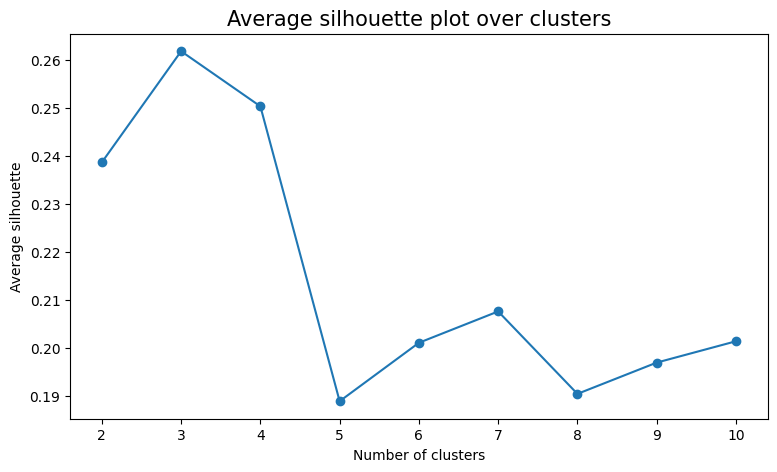

In [11]:
plt.figure(figsize=(9, 5))
plt.plot(K, silhouettes, marker='o')
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

# MeanShift Clustering
MeanShift is a non-parametric clustering technique which does not require prior knowledge of the number of clusters. It works by updating candidates for centroids to be the mean of the points within a given region.


In [12]:
# Estimate bandwidth for MeanShift
bandwidth = estimate_bandwidth(model_df_clipped, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_labels = ms.fit_predict(model_df_clipped)

ms_n_clusters = len(np.unique(ms_labels))
print(f"Number of clusters estimated by MeanShift: {ms_n_clusters}")

if ms_n_clusters > 1:
    ms_sil = silhouette_score(model_df_clipped, ms_labels)
    print(f"MeanShift Silhouette Score: {ms_sil:.4f}")
else:
    print("MeanShift only found 1 cluster. Try adjusting the bandwidth.")


Number of clusters estimated by MeanShift: 1
MeanShift only found 1 cluster. Try adjusting the bandwidth.


# Segmented Clustering
As requested, we will now perform clustering on the behavioral and profile features separately to see if we can find more distinct segments.


In [13]:
# Behavioral Segmentation
print("--- Behavioral Segmentation ---")
X_behavior = model_df_clipped[behavior_features]
kmeans_behavior = KMeans(n_clusters=4, random_state=42, n_init=20).fit(X_behavior)
print(f"Behavior Silhouette: {silhouette_score(X_behavior, kmeans_behavior.labels_):.4f}")

# Profile Segmentation
print("\n--- Profile Segmentation ---")
X_profile = model_df_clipped[profile_features]
kmeans_profile = KMeans(n_clusters=4, random_state=42, n_init=20).fit(X_profile)
print(f"Profile Silhouette: {silhouette_score(X_profile, kmeans_profile.labels_):.4f}")


--- Behavioral Segmentation ---
Behavior Silhouette: 0.6136

--- Profile Segmentation ---
Profile Silhouette: 0.2483
